In [ ]:
!pip install -U pandas-profiling

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sqlalchemy import create_engine
import seaborn as sns
import sklearn.metrics as metrics
import pandas_profiling as pp
import pickle
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
%matplotlib inline

In [2]:
df_Cardio = pd.read_csv('Cardio_Disease.csv')
df_Cardio

,id,age_days,age_year,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,50.391781,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,55.419178,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,51.663014,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,48.282192,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,47.873973,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,52.712329,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,61.920548,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,52.235616,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,61.454795,1,163,72.0,135,80,1,2,0,0,0,1


In [3]:
engine=create_engine("sqlite://", echo=False)
df_Cardio.to_sql('Cardio_Disease', con=engine)

In [4]:
df=pd.read_sql('SELECT * FROM Cardio_Disease', engine)
df

,index,id,age_days,age_year,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,0,18393,50.391781,2,168,62.0,110,80,1,1,0,0,1,0
1,1,1,20228,55.419178,1,156,85.0,140,90,3,1,0,0,1,1
2,2,2,18857,51.663014,1,165,64.0,130,70,3,1,0,0,0,1
3,3,3,17623,48.282192,2,169,82.0,150,100,1,1,0,0,1,1
4,4,4,17474,47.873973,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,69995,99993,19240,52.712329,2,168,76.0,120,80,1,1,1,0,1,0
69996,69996,99995,22601,61.920548,1,158,126.0,140,90,2,2,0,0,1,1
69997,69997,99996,19066,52.235616,2,183,105.0,180,90,3,1,0,1,0,1
69998,69998,99998,22431,61.454795,1,163,72.0,135,80,1,2,0,0,0,1


The dataset consists of 70,000 records of patients data in 15 features, such as age, gender, systolic blood pressure, diastolic blood pressure, and etc. The target class "cardio" equals to 1, when patient has cardiovascular desease, and it's 0, if patient is healthy.

The task is to predict the presence or absence of cardiovascular disease (CVD) using the patient examination results

In [5]:
df_Cardio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age_days     70000 non-null  int64  
 2   age_year     70000 non-null  float64
 3   gender       70000 non-null  int64  
 4   height       70000 non-null  int64  
 5   weight       70000 non-null  float64
 6   ap_hi        70000 non-null  int64  
 7   ap_lo        70000 non-null  int64  
 8   cholesterol  70000 non-null  int64  
 9   gluc         70000 non-null  int64  
 10  smoke        70000 non-null  int64  
 11  alco         70000 non-null  int64  
 12  active       70000 non-null  int64  
 13  cardio       70000 non-null  int64  
dtypes: float64(2), int64(12)
memory usage: 7.5 MB


In [6]:
pp.ProfileReport(df_Cardio, minimal=True )

# EDA

In [7]:
# Values of the gender feature were not expailned (whether "1" stands for women or men) 
#This out by looking analyzing height, reasonably assuming that on average men are taller.
df_Cardio.groupby('gender')['height'].mean()

gender
1    161.355612
2    169.947895
Name: height, dtype: float64

So we make a conclude that gender = 1 represents females, and gender = 2 represents men

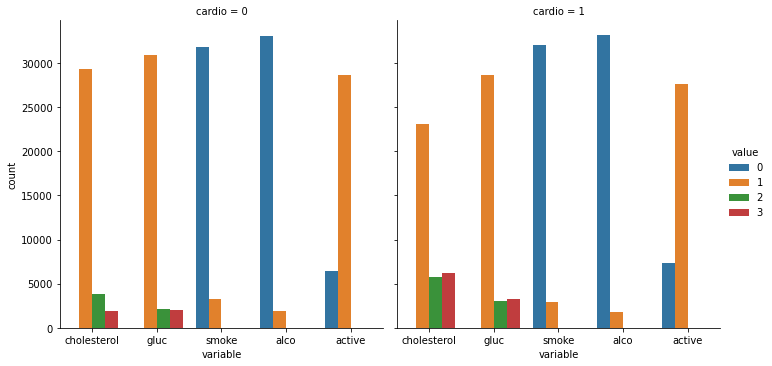

In [8]:
df_ = pd.melt(df_Cardio, id_vars=['cardio'], value_vars=['cholesterol','gluc', 'smoke', 'alco', 'active'])
sns.catplot(x="variable", hue="value", col="cardio", data=df_, kind="count")

It can be clearly seen that patients with CVD have higher cholesterol and blood glucose level.
And, generally speaking less active.

### Check imbalanced data 

<AxesSubplot:>

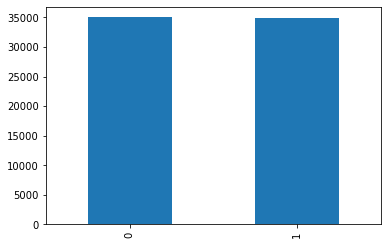

In [9]:
df_Cardio['cardio'].value_counts()
df_Cardio['cardio'].value_counts().plot.bar()

In [10]:
print('Proportion of the classes in the data:')
print(df_Cardio['cardio'].value_counts() / len(df_Cardio))

Proportion of the classes in the data:
0    0.5003
1    0.4997
Name: cardio, dtype: float64


We can cleary say our dataset in balance

## Data Cleaning

In [11]:
df_Cardio.isnull().values.any()

False

In [12]:
df_Cardio['age_year'] =df_Cardio['age_year'].astype(int)
df_Cardio['weight'] =df_Cardio['weight'].astype(int)

In [13]:
df_Cardio.drop(["age_days" , "id"], axis=1, inplace = True)

In [14]:
df_Cardio.rename({'age_year': 'age'}, axis='columns' , inplace=True )

In [15]:
df_Cardio.duplicated().sum()

3213

In [16]:
df_Cardio.drop_duplicates(inplace = True)

In [17]:
df_Cardio.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [18]:
df_Cardio.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,66787.000000,66787.000000,66787.000000,66787.000000,66787.000000,66787.000000,66787.000000,66787.000000,66787.000000,66787.000000,66787.000000,66787.000000
mean,52.859509,1.356222,164.341668,74.519802,129.232126,97.447677,1.382739,1.236124,0.092144,0.056298,0.798554,0.511956
std,6.803802,0.478886,8.334176,14.581158,157.655220,192.913579,0.690148,0.582081,0.289231,0.230499,0.401084,0.499861
min,29.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,53.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,58.000000,2.000000,170.000000,83.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,64.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
df_Cardio.corr()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
age,1.000000,-0.023476,-0.083382,0.052915,0.020842,0.017537,0.155555,0.098854,-0.049248,-0.030903,-0.009609,0.235311
gender,-0.023476,1.000000,0.503819,0.149709,0.005229,0.014212,-0.043254,-0.025656,0.340396,0.170863,0.009714,0.001505
height,-0.083382,0.503819,1.000000,0.291907,0.005622,0.006359,-0.049440,-0.017813,0.190483,0.095819,-0.006442,-0.009648
weight,0.052915,0.149709,0.291907,1.000000,0.029672,0.042119,0.134030,0.101421,0.061998,0.062770,-0.011400,0.175439
ap_hi,0.020842,0.005229,0.005622,0.029672,1.000000,0.015824,0.022614,0.010963,-0.001720,0.000783,0.000722,0.053899
ap_lo,0.017537,0.014212,0.006359,0.042119,0.015824,1.000000,0.022094,0.009345,0.003922,0.009611,0.006051,0.064844
cholesterol,0.155555,-0.043254,-0.049440,0.134030,0.022614,0.022094,1.000000,0.444595,0.003572,0.030675,0.018249,0.213952
gluc,0.098854,-0.025656,-0.017813,0.101421,0.010963,0.009345,0.444595,1.000000,-0.009793,0.007385,-0.000269,0.081641
smoke,-0.049248,0.340396,0.190483,0.061998,-0.001720,0.003922,0.003572,-0.009793,1.000000,0.337689,0.030164,-0.023052
alco,-0.030903,0.170863,0.095819,0.062770,0.000783,0.009611,0.030675,0.007385,0.337689,1.000000,0.028900,-0.013250


<AxesSubplot:>

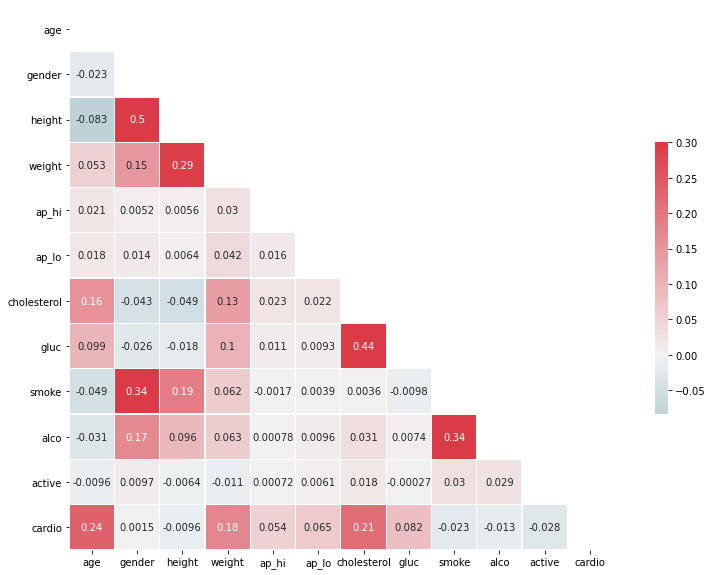

In [20]:
# Plot the correlations between the variables
plt.figure(figsize = (15,10))
mask = np.zeros_like(df_Cardio.corr())
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_Cardio.corr(), cmap=cmap, mask=mask, vmax=.3, center=0,annot = True, square=True, linewidths=.25, cbar_kws={"shrink": .5})

As shown below cardio disease is more relative with AGE, WEIGHT and CHOLESTEROL

### Outliers

<AxesSubplot:>

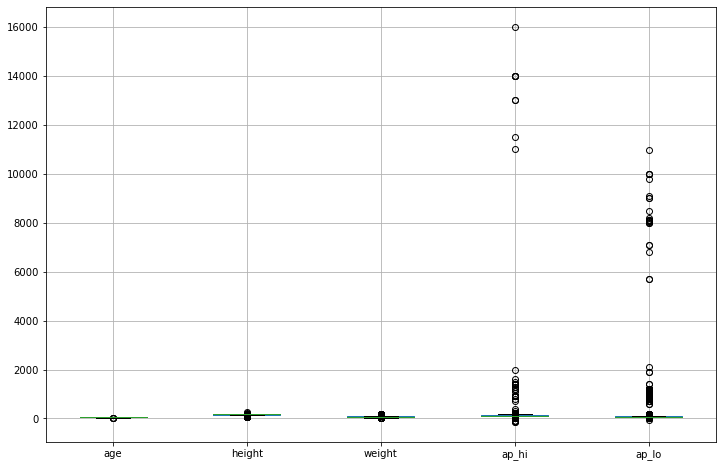

In [21]:
outlier =['age', 'height', 'weight', 'ap_hi', 'ap_lo']
plt.figure(figsize = (12,8))
df_Cardio.boxplot(outlier)

#### Remove Outliers

In [22]:
def is_outlier_IQR(df, x):
    Q1 = df[x].quantile(0.25)
    Q3 = df[x].quantile(0.75)
    IQR = Q3 - Q1
    high = Q3 + 1.5 * IQR
    low = Q1 - 1.5 * IQR
    return df[~((df[x] < low) |(df[x] > high))]

for x in outlier:
    df_Cardio = is_outlier_IQR(df_Cardio, x)

## Detecting Multicollinearity with VIF

In [23]:
indep =df_Cardio[['age', 'weight','cholesterol']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = indep.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(indep.values, i)
                          for i in range(len(indep.columns))]
  
print(vif_data)

       feature        VIF
0          age  26.059406
1       weight  24.846328
2  cholesterol   5.198452


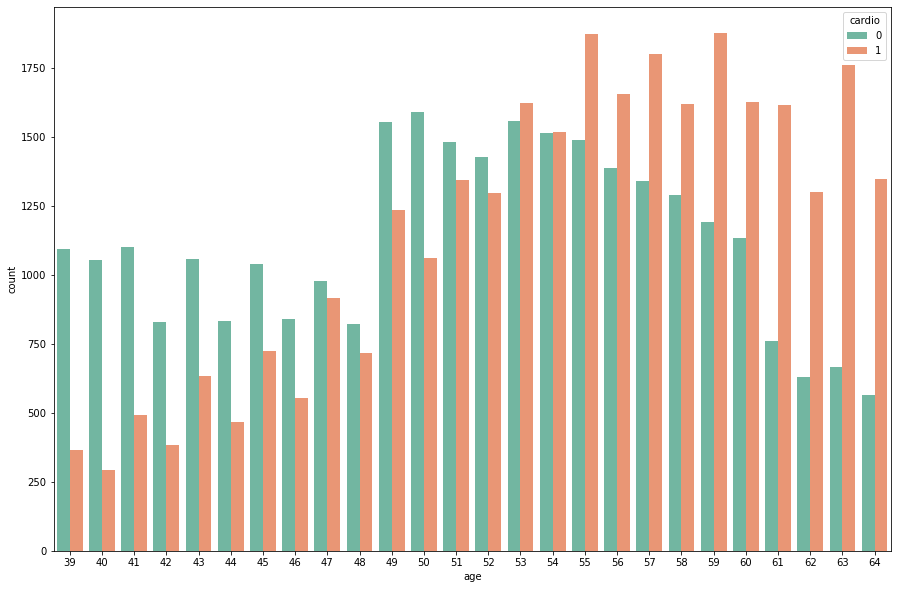

In [24]:
rcParams['figure.figsize'] = 15, 10
sns.countplot(x='age', hue='cardio', data = df_Cardio, palette="Set2");
#It can be observed that people over 53 of age are more exposed to CVD. From the table above

As we can see, height and weight have very high values of VIF,
indicating that these two variables are highly correlated. 

This is expected as the height of a person does influence their weight.
Hence, considering these two features together leads to a model with high multicollinearity

# Feature Engineering

It can be seen that the factors that mainly affect the 'cardio' feature are: blood pressure, cholesterol, age and bmi.

Delete the subjective columns that have no correlation with the target feature.

In [25]:
df_Cardio=df_Cardio.drop(['active','alco','smoke'],axis=1)

BMI =(Weight IN KG / (Height IN M )^2)

This feature represents the 'height' ,'weight' features and can therefore be deleted

In [26]:
df_Cardio['bmi'] = df_Cardio['weight']/((df_Cardio['height']/100)**2)
df_Cardio=df_Cardio.drop(['height','weight'],axis=1)

In [27]:
df_Cardio=df_Cardio.iloc[:,[0,1,2,3,4,5,7,6]]

In [28]:
df_Cardio

,age,gender,ap_hi,ap_lo,cholesterol,gluc,bmi,cardio
0,50,2,110,80,1,1,21.967120,0
1,55,1,140,90,3,1,34.927679,1
2,51,1,130,70,3,1,23.507805,1
3,48,2,150,100,1,1,28.710479,1
5,60,1,120,80,2,2,29.384676,0
...,...,...,...,...,...,...,...,...
69992,51,1,170,90,1,1,21.604105,1
69993,53,1,130,90,1,1,23.661439,1
69994,57,1,150,80,1,1,29.384757,1
69998,61,1,135,80,1,2,27.099251,1


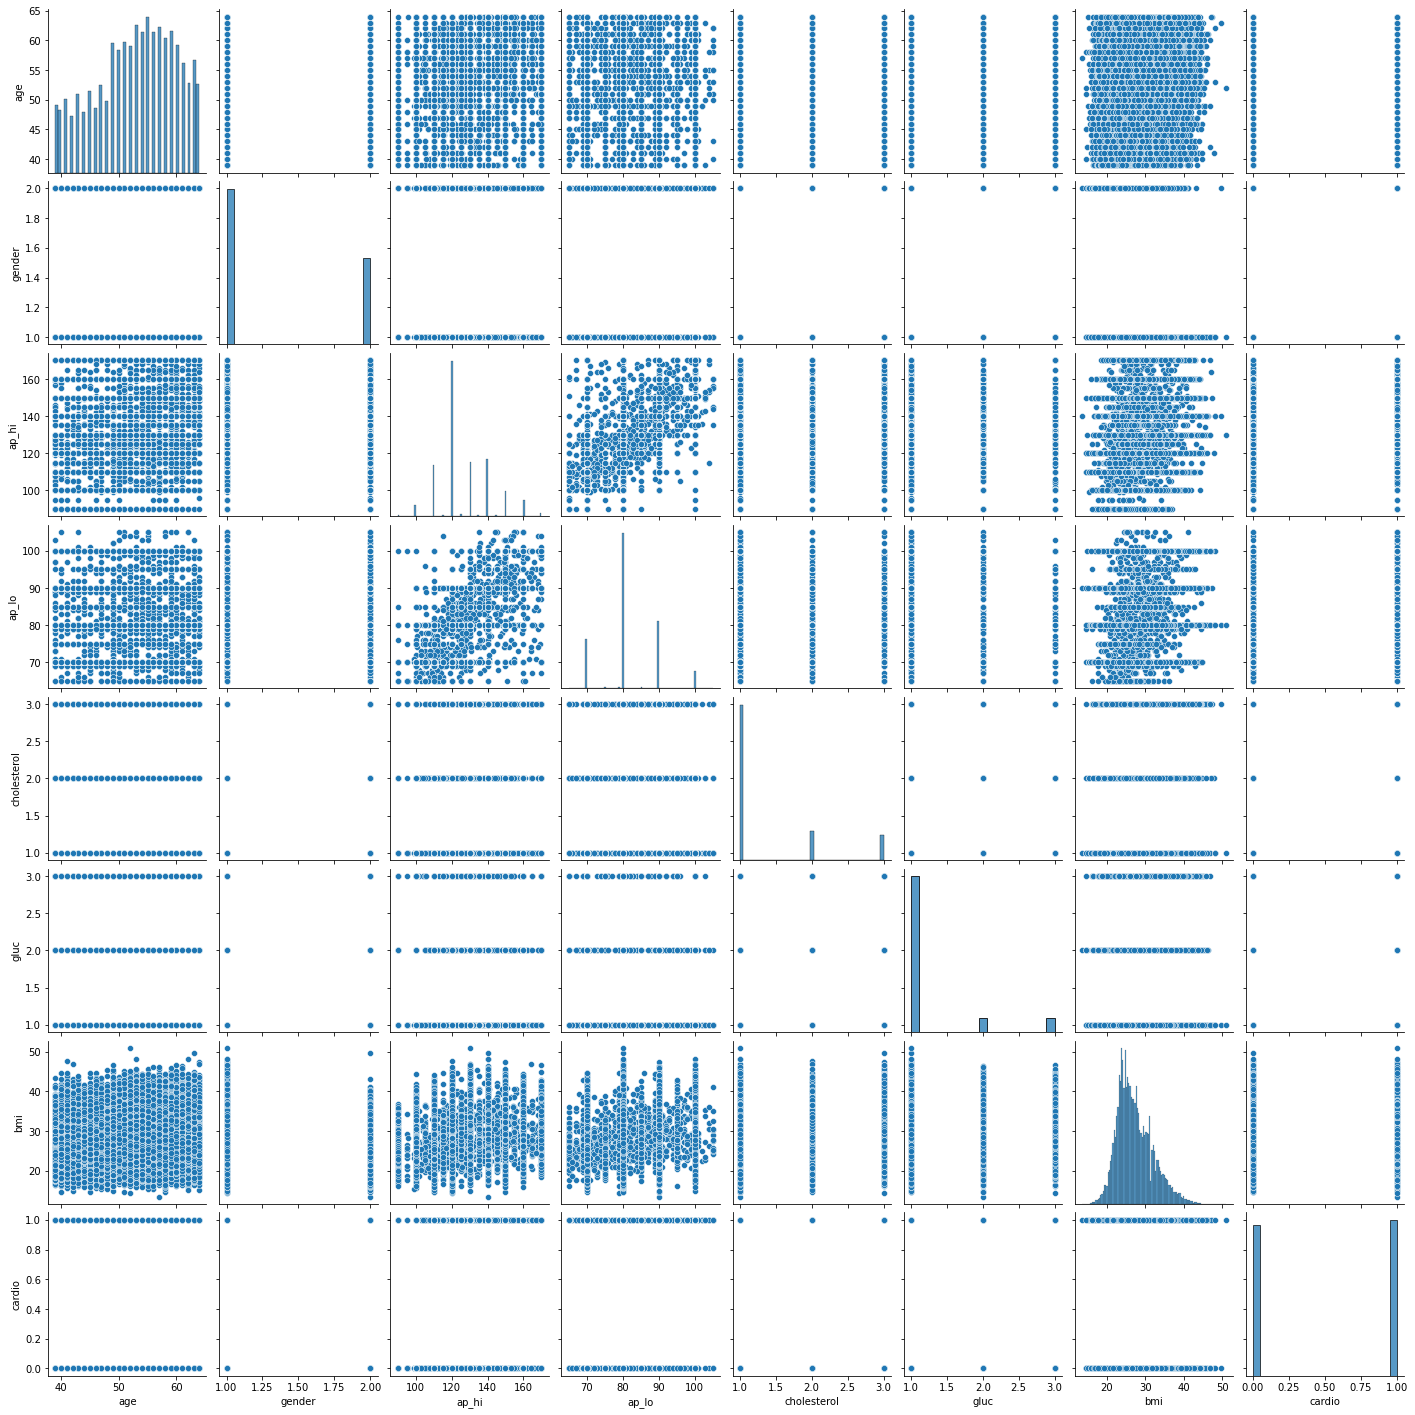

In [29]:
sns.pairplot(df_Cardio)

In [30]:
df_Cardio.to_csv('Cardio_Disease1.csv', index=False, encoding='utf-8')